In [277]:
import tensorflow as tf
import numpy as np
from importlib.machinery import SourceFileLoader
tfFns = SourceFileLoader("tfFns.py", "/home/msmith/misc/tfFunctions/tfFns.py").load_module()
from numpy import prod
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
from tqdm import tnrange, tqdm_notebook
from time import sleep
import math

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [319]:
batchSize = 10
x = tf.placeholder(tf.float32, shape=[batchSize, 784])

#Encoding layers
xReshape = tf.reshape(x, [batchSize,28,28,1])

feats = 16
W_conv1 = tfFns.weight_variable([3, 3, 1, feats])
b_conv1 = tfFns.bias_variable([feats])

W_conv2 = tfFns.weight_variable([3, 3, feats, feats])
b_conv2 = tfFns.bias_variable([feats])

W_conv3 = tfFns.weight_variable([3, 3, feats, feats])
b_conv3 = tfFns.bias_variable([feats])

W_conv4 = tfFns.weight_variable([3, 3, feats, feats])
b_conv4 = tfFns.bias_variable([feats])

#Decoding layers
outputShape5 = [batchSize,8,8,feats]
W_deconv1 = tfFns.weight_variable([3, 3, feats, feats])
b_deconv1 = tfFns.bias_variable([feats])

outputShape6 = [batchSize,16,16,1]
W_deconv2 = tfFns.weight_variable([3, 3, 1, feats])
b_deconv2 = tfFns.bias_variable([1])

'''
outputShape7 = [batchSize,28,28,1]
W_deconv3 = tfFns.weight_variable([3, 3, 1, feats])
b_deconv3 = tfFns.bias_variable([1])
'''

h_conv1 = tf.nn.relu(tfFns.conv2d(xReshape, W_conv1) + b_conv1)
h_pool1 = tfFns.max_pool_2x2(h_conv1)

h_conv2 = tf.nn.relu(tfFns.conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = tfFns.max_pool_2x2(h_conv2)

h_conv3 = tf.nn.relu(tfFns.conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = tfFns.max_pool_2x2(h_conv3)

h_conv4 = tf.nn.relu(tfFns.conv2d(h_pool3, W_conv4) + b_conv4)

h_deconv1 = tf.nn.relu(tfFns.deconv2d(h_conv4, W_deconv1, output_shape=outputShape5) + b_deconv1)

yPred = tf.nn.relu(tfFns.deconv2d(h_deconv1, W_deconv2, output_shape=outputShape6) + b_deconv2)

'''
h_deconv2 = tf.nn.relu(tfFns.deconv2d(h_deconv1,W_deconv2,output_shape=outputShape6) + b_deconv2)

yPred = tf.nn.sigmoid(tfFns.deconv2d(h_deconv2,W_deconv3,output_shape=outputShape7) + b_deconv3)
'''
yPredShape = yPred.get_shape().as_list()
xResize = tf.image.resize_bilinear(xReshape,(yPredShape[1],yPredShape[2]))
mse = tf.reduce_sum(tf.square(yPred - xResize))
train_step = tf.train.AdamOptimizer(0.01).minimize(mse)

for l in [x,x_image,h_conv1,h_pool1,h_conv2,h_pool2,h_conv3, h_conv4, yPred, xResize, mse]:
    print("shape, elements = %s, %s." % (l.get_shape(),prod(l.get_shape().as_list()[1:])))

shape, elements = (10, 784), 784.
shape, elements = (10, 28, 28, 1), 784.
shape, elements = (10, 28, 28, 16), 12544.
shape, elements = (10, 14, 14, 16), 3136.
shape, elements = (10, 14, 14, 16), 3136.
shape, elements = (10, 7, 7, 16), 784.
shape, elements = (10, 7, 7, 16), 784.
shape, elements = (10, 4, 4, 16), 256.
shape, elements = (10, 16, 16, 1), 256.
shape, elements = (10, 16, 16, 1), 256.
shape, elements = (), 1.0.


In [320]:
def hstackBatch(batch):
    batch = batch.squeeze()
    batchSize = batch.shape[0]
    x = batch[0]
    for i in range(1,batchSize):
        x = np.hstack((x,batch[i]))
    return x

def getImgsFrmClass(Class):
    idx = mnist.test.labels.argmax(1) == Class
    imgs = mnist.test.images[idx]
    return imgs

def batchGen(Class,batchSize):
    imgs = getImgsFrmClass(Class)
    n,shape = imgs.shape
    idx = 0
    while True:
        newBatch = np.empty((batchSize,shape))
        for i in range(batchSize):
            newBatch[i] = imgs[idx]
            idx += 1
            if idx == n:
                idx = 0
        yield newBatch


Mean loss after 0 iterations of batch size 10 = 235.038498 
Number/Class = 0


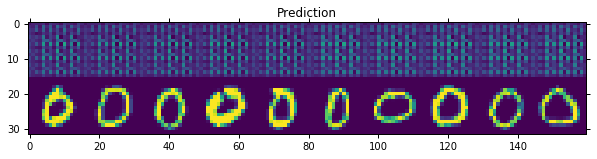

Number/Class = 1


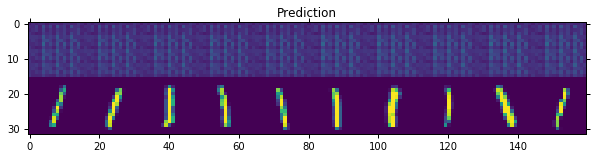

Number/Class = 2


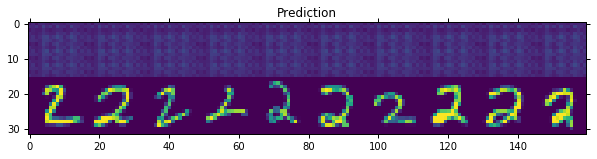

Number/Class = 3


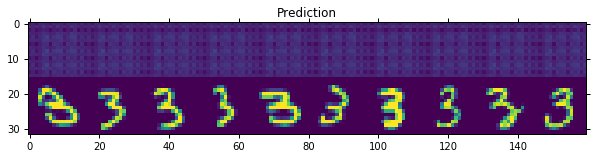

Number/Class = 4


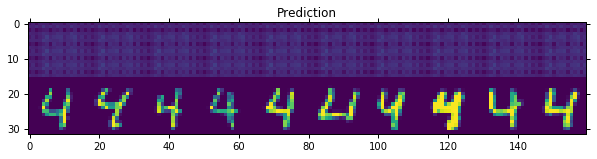

Number/Class = 5


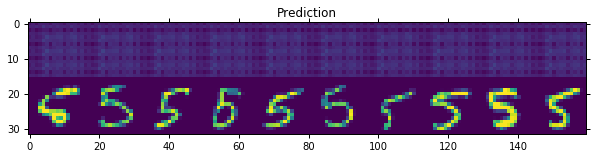

Number/Class = 6


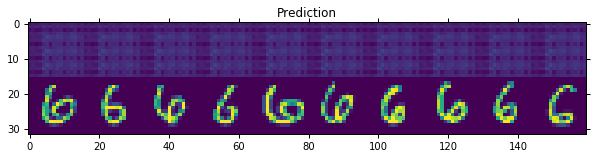

Number/Class = 7


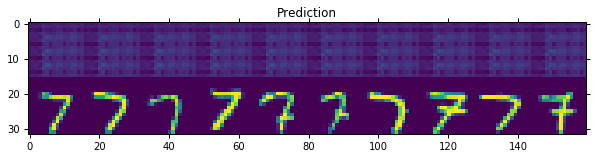

Number/Class = 8


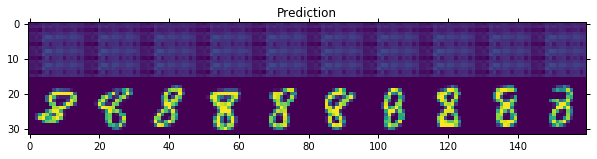

Number/Class = 9


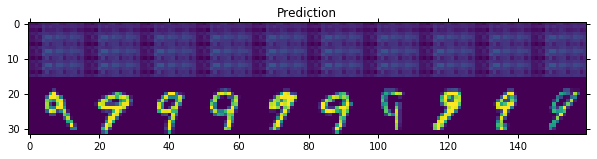

Mean loss after 2000 iterations of batch size 10 = 39.934471 
Number/Class = 0


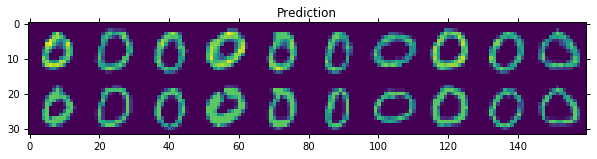

Number/Class = 1


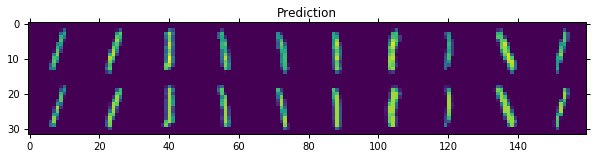

Number/Class = 2


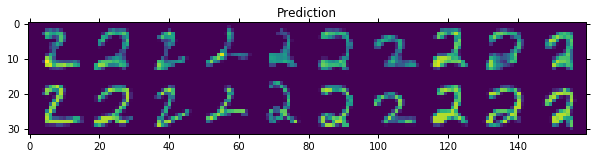

Number/Class = 3


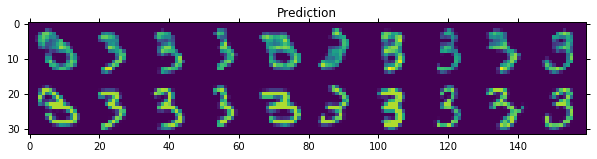

Number/Class = 4


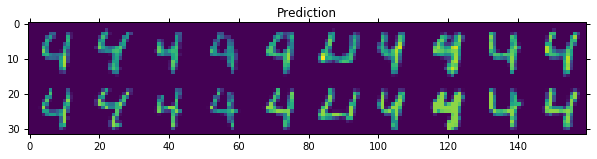

Number/Class = 5


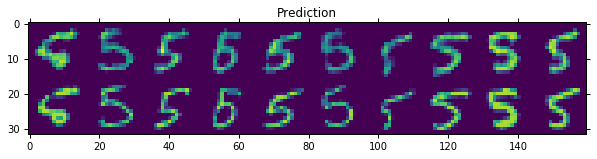

Number/Class = 6


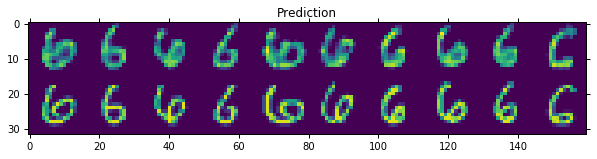

Number/Class = 7


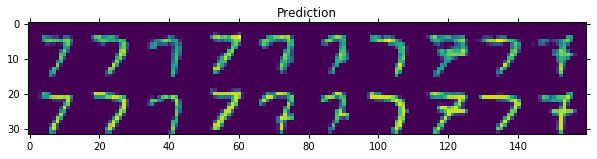

Number/Class = 8


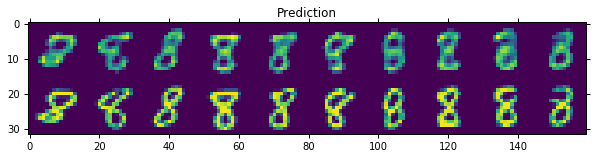

Number/Class = 9


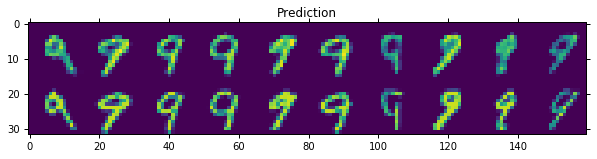

Mean loss after 4000 iterations of batch size 10 = 34.058414 
Number/Class = 0


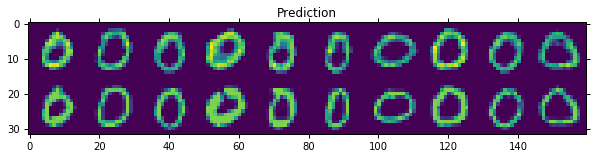

Number/Class = 1


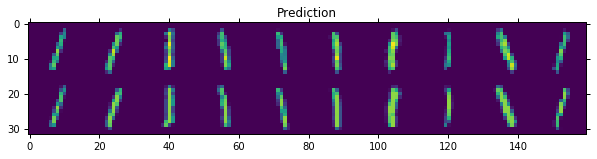

Number/Class = 2


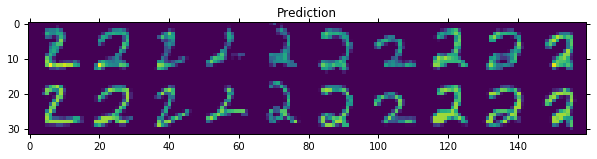

Number/Class = 3


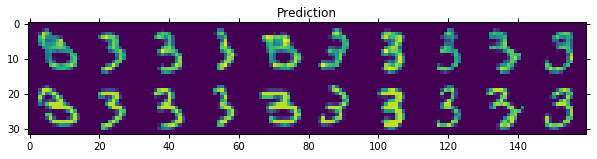

Number/Class = 4


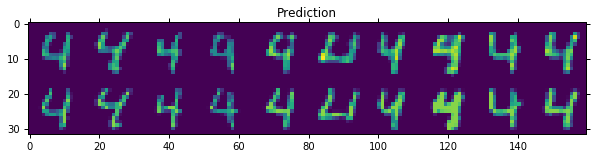

Number/Class = 5


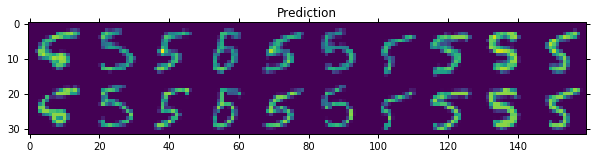

Number/Class = 6


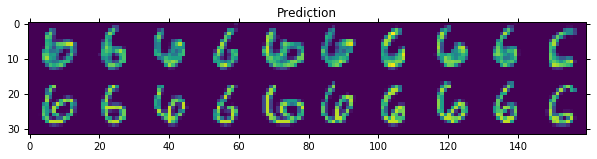

Number/Class = 7


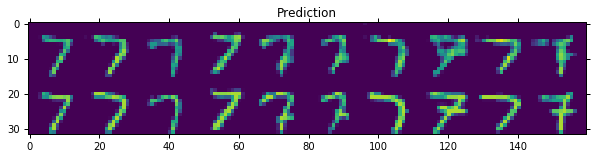

Number/Class = 8


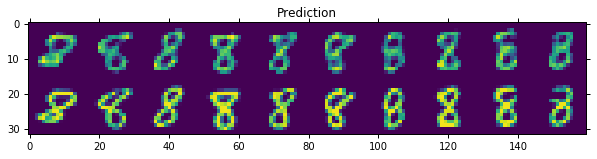

Number/Class = 9


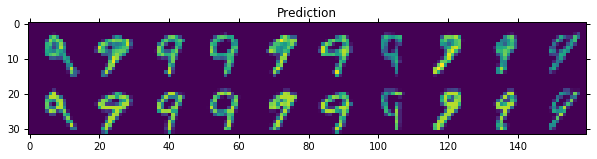

Mean loss after 6000 iterations of batch size 10 = 31.571621 
Number/Class = 0


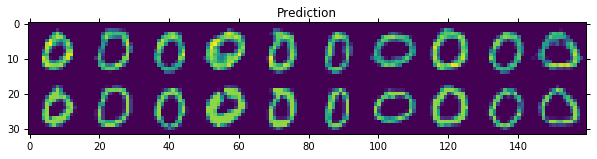

Number/Class = 1


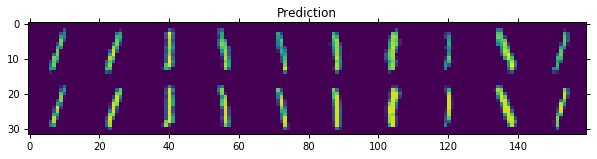

Number/Class = 2


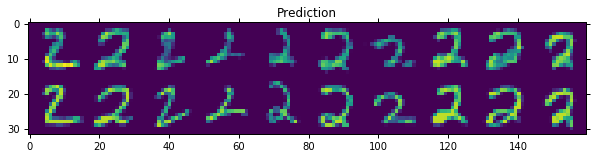

Number/Class = 3


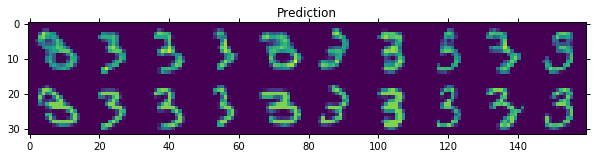

Number/Class = 4


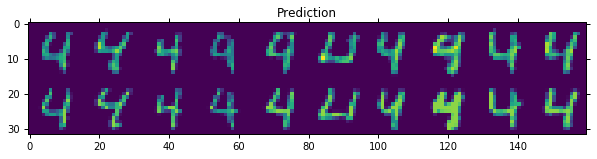

Number/Class = 5


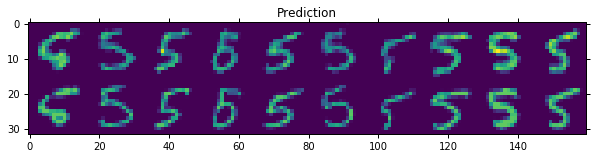

Number/Class = 6


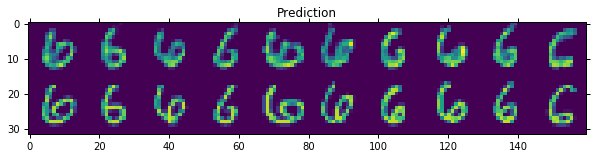

Number/Class = 7


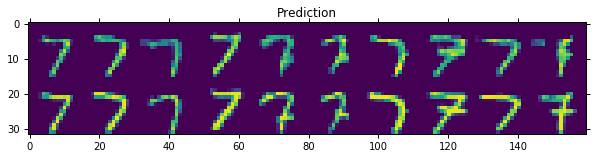

Number/Class = 8


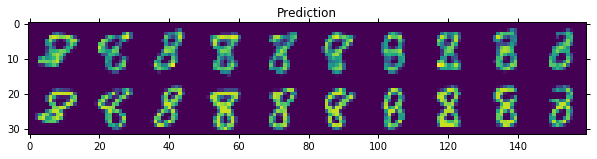

Number/Class = 9


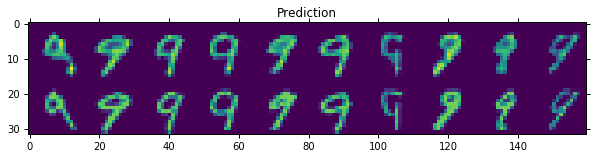

Mean loss after 8000 iterations of batch size 10 = 30.071081 
Number/Class = 0


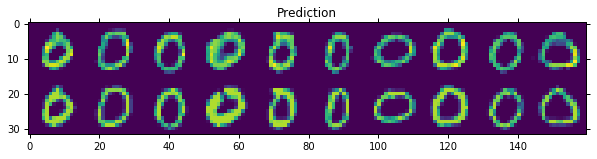

Number/Class = 1


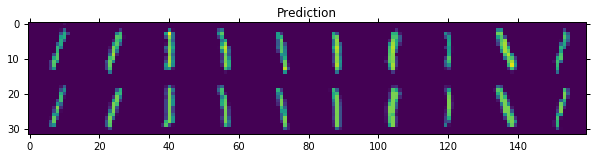

Number/Class = 2


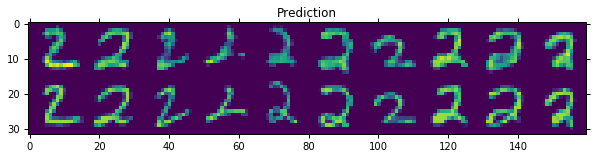

Number/Class = 3


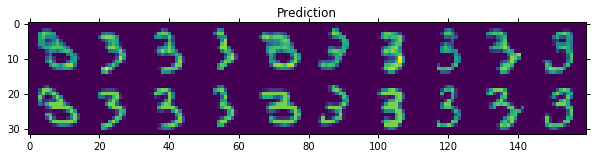

Number/Class = 4


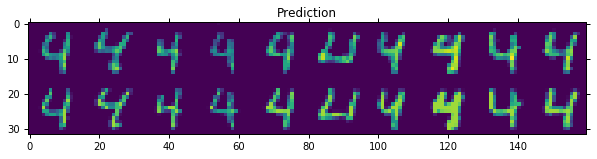

Number/Class = 5


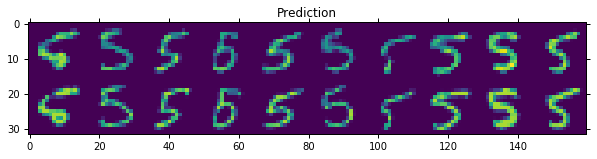

Number/Class = 6


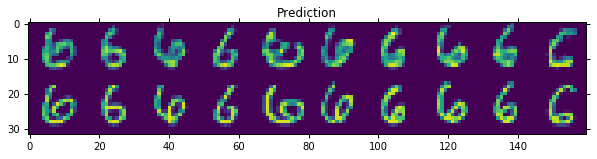

Number/Class = 7


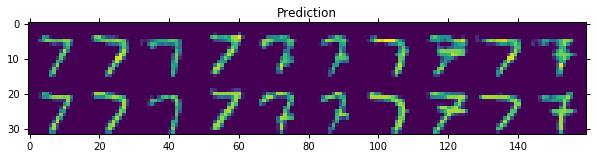

Number/Class = 8


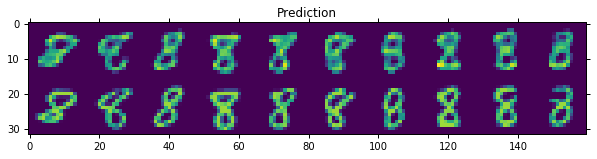

Number/Class = 9


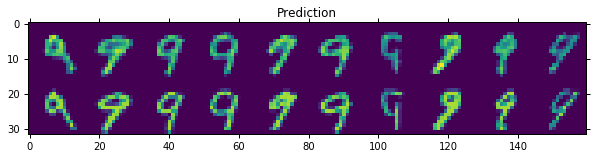

Mean loss after 10000 iterations of batch size 10 = 29.041571 
Number/Class = 0


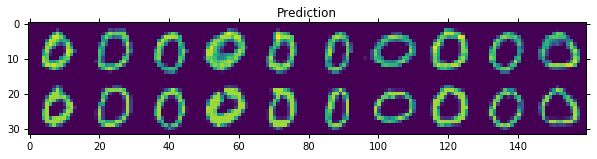

Number/Class = 1


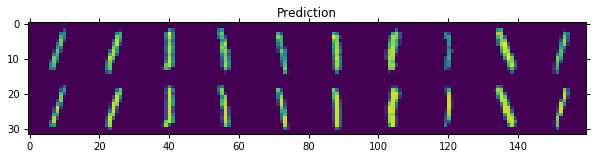

Number/Class = 2


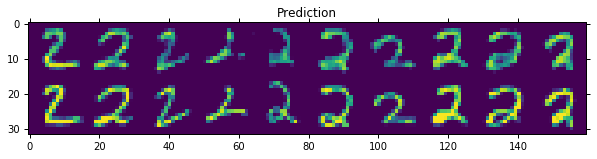

Number/Class = 3


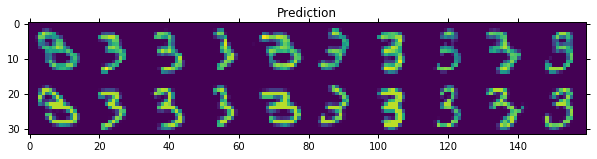

Number/Class = 4


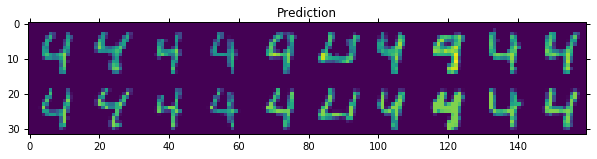

Number/Class = 5


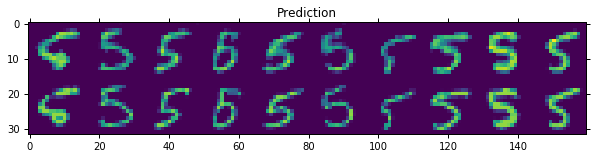

Number/Class = 6


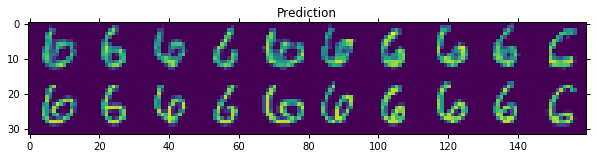

Number/Class = 7


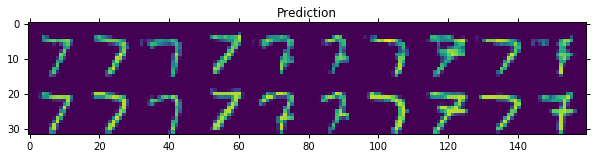

Number/Class = 8


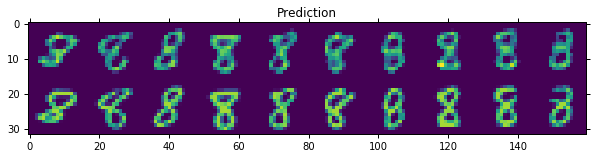

Number/Class = 9


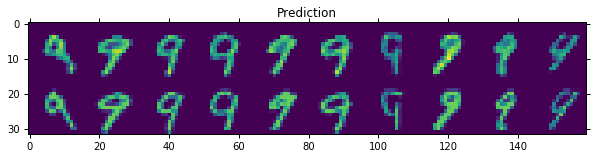

Mean loss after 12000 iterations of batch size 10 = 28.311337 
Number/Class = 0


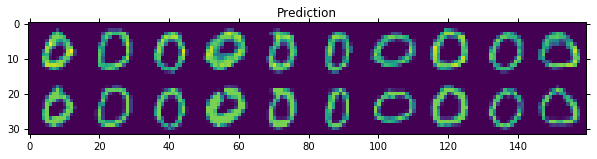

Number/Class = 1


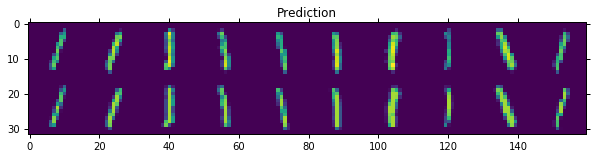

Number/Class = 2


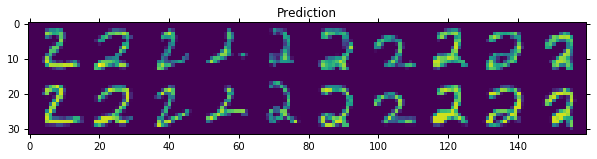

Number/Class = 3


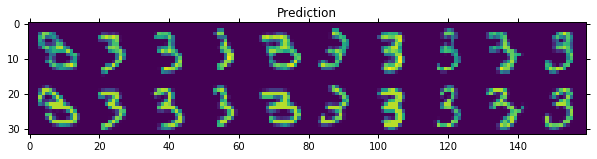

Number/Class = 4


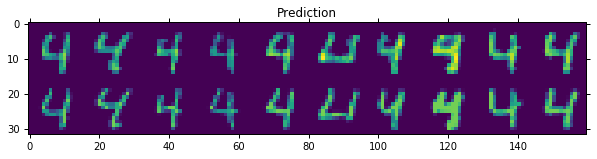

Number/Class = 5


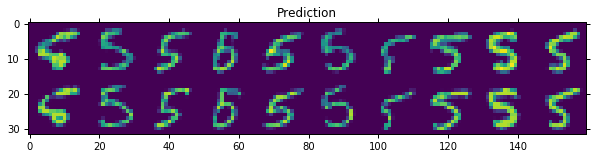

Number/Class = 6


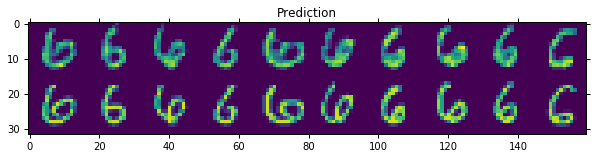

Number/Class = 7


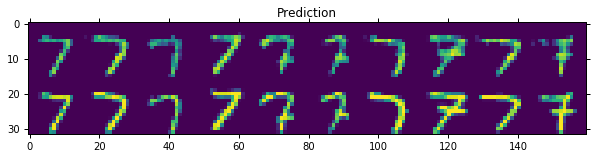

Number/Class = 8


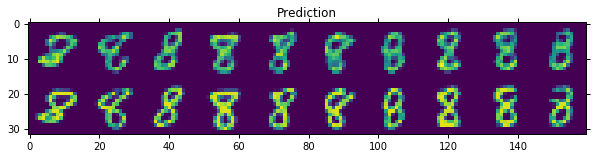

Number/Class = 9


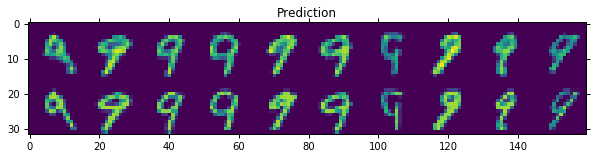

Mean loss after 14000 iterations of batch size 10 = 27.727369 
Number/Class = 0


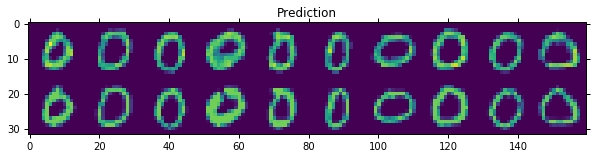

Number/Class = 1


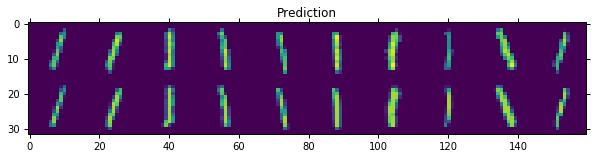

Number/Class = 2


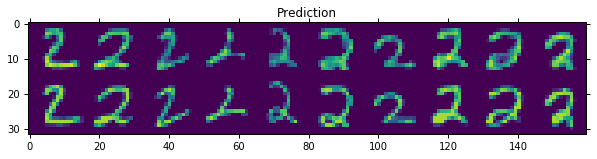

Number/Class = 3


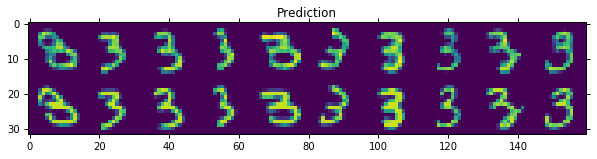

Number/Class = 4


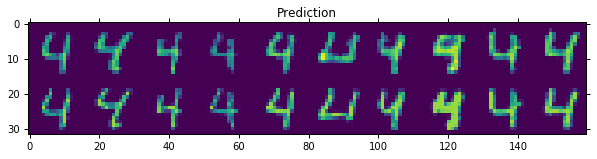

Number/Class = 5


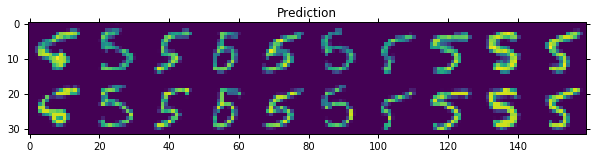

Number/Class = 6


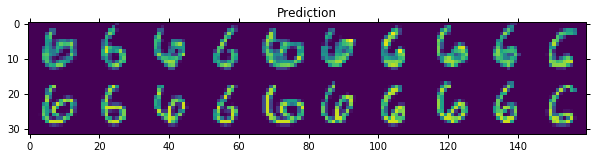

Number/Class = 7


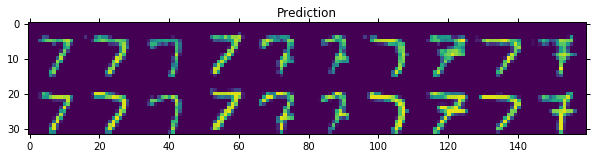

Number/Class = 8


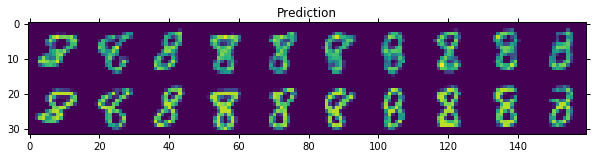

Number/Class = 9


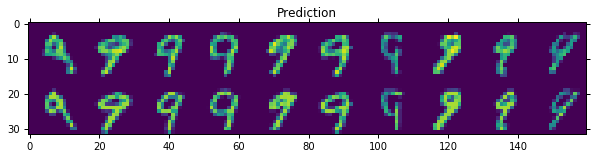

Mean loss after 16000 iterations of batch size 10 = 27.236391 
Number/Class = 0


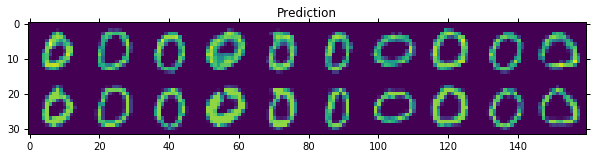

Number/Class = 1


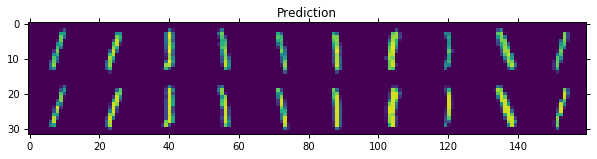

Number/Class = 2


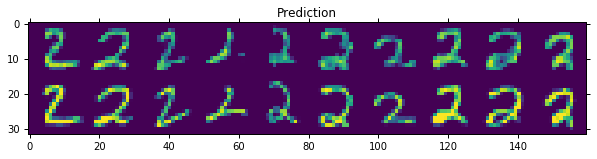

Number/Class = 3


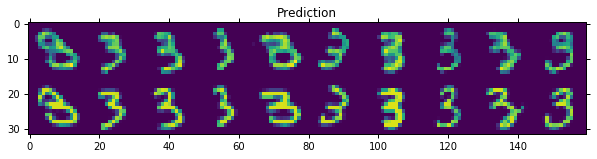

Number/Class = 4


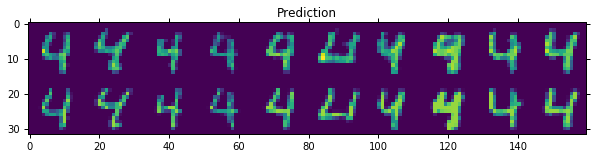

Number/Class = 5


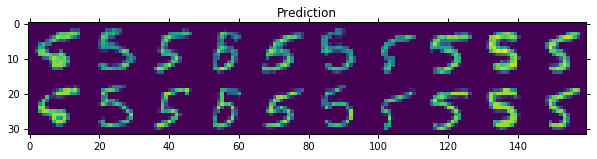

Number/Class = 6


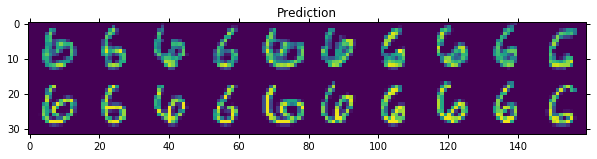

Number/Class = 7


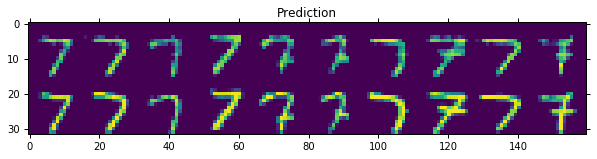

Number/Class = 8


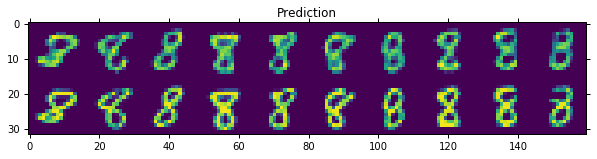

Number/Class = 9


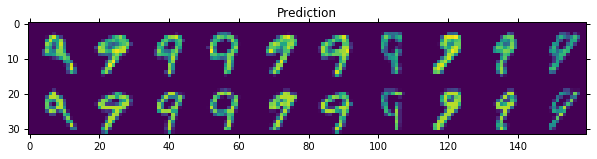

Mean loss after 18000 iterations of batch size 10 = 26.822454 
Number/Class = 0


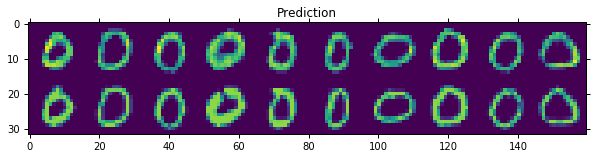

Number/Class = 1


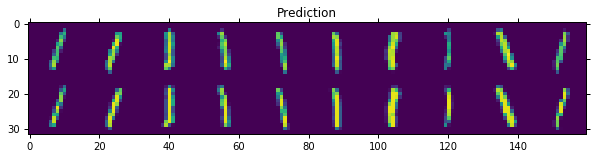

Number/Class = 2


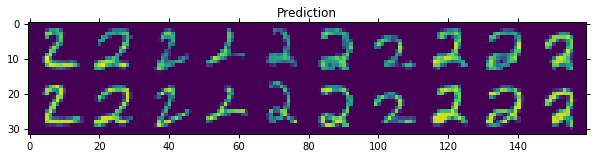

Number/Class = 3


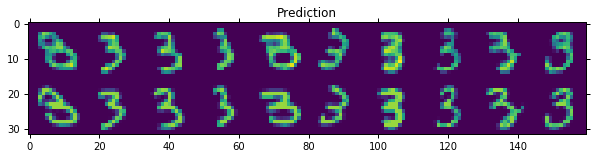

Number/Class = 4


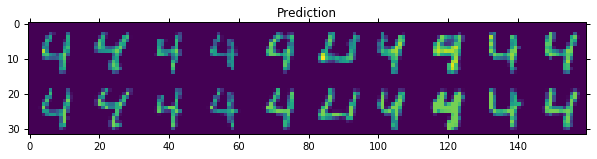

Number/Class = 5


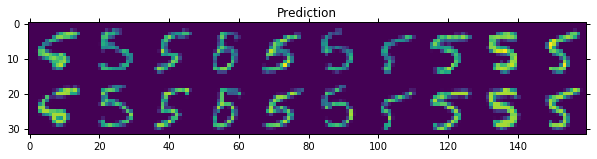

Number/Class = 6


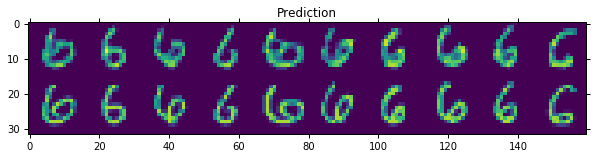

Number/Class = 7


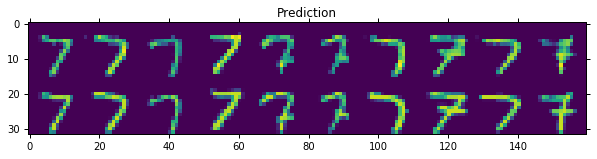

Number/Class = 8


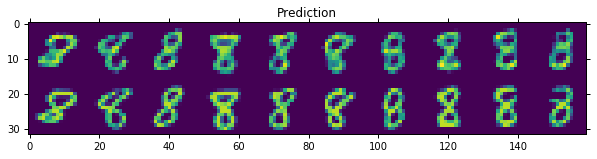

Number/Class = 9


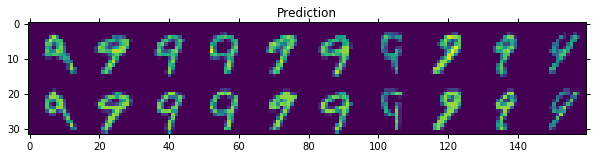

In [321]:

ma = 2000
iterations = int(2e4)
mseAv = []
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in tqdm_notebook(range(iterations),desc='1st loop'):
        batchX, batchY = mnist.train.next_batch(batchSize)
        _, mse_, yPred_, xResize_, xReshape_ = sess.run([train_step,mse,yPred,xResize,xReshape],feed_dict={x: batchX})
        mseAv.append(mse_)
        if i % ma == 0:
            print("Mean loss after %d iterations of batch size %d = %f " % (i,batchSize,np.array(mseAv).mean()))

            for number in range(10):
                numGen = batchGen(number,batchSize)
                _, mse_, yPred_, xResize_, xReshape_ = sess.run([train_step,mse,yPred,xResize,xReshape],feed_dict={x: next(numGen)})
                print("Number/Class = %d" % number)
                plt.title("Prediction")
                plt.imshow(np.vstack((hstackBatch(yPred_),hstackBatch(xResize_))))
                plt.show()